In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
df.describe()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.682379,0.234568,...,0.760943,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122,0.188552,0.086420,0.722783
std,0.486592,14.526497,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.465813,0.423966,...,0.426747,0.339154,0.286037,0.074743,0.066890,0.074743,0.033501,0.391372,0.281141,0.447876
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
real_features = ['Age', 'Fare']
cat_features = list(set(df.columns.values.tolist()) - set(real_features) )
cat_features.remove('Survived')
print (cat_features)

['SibSp_5', 'Parch_1', 'Parch_0', 'Sex_male', 'Pclass_3', 'SibSp_0', 'Parch_5', 'Parch_4', 'SibSp_8', 'Embarked_C', 'SibSp_3', 'SibSp_1', 'Pclass_2', 'Embarked_Q', 'Sex_female', 'Pclass_1', 'SibSp_4', 'Parch_2', 'Embarked_S', 'SibSp_2', 'Parch_6', 'Parch_3']


In [6]:
print (df.shape)

(891, 25)


In [7]:
df['Age'] = df['Age'].fillna(0)

In [8]:
y = df['Survived'].to_numpy()
df = df.drop('Survived', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [22.    7.25] 
X_cat: [0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0] 
y: 0 


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

In [10]:
#selected_features = (0, 1, 2, 5, 7, 9, 10, 12, 14, 16, 17, 18, 19, 21, 22)

In [11]:
X = np.hstack((X_real, X_cat))
#X = X[:,selected_features]

print (X.shape, y.shape)

(891, 24) (891,)


## Decision tree and Ensemble methods

In [12]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
tree = DecisionTreeClassifier()

score = cross_val_score(tree, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

0.7711304051753489


In [41]:
bc1_model = BaggingClassifier(n_estimators=100)

score = cross_val_score(bc1_model, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

0.8071246169560776


In [42]:
mf = int(np.sqrt(X.shape[1]))
print (X.shape[1], mf)
bc2_model = BaggingClassifier(n_estimators=100, max_features=mf)

score = cross_val_score(bc2_model, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

24 4
0.7991845420497106


In [43]:
mf = int(np.sqrt(X.shape[1]))
print (X.shape[1], mf)

tree = DecisionTreeClassifier(max_features=mf)
bc3_model = BaggingClassifier(base_estimator=tree, n_estimators=100)

score = cross_val_score(bc3_model, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

24 4
0.7925048235160596


In [17]:
rf_model = RandomForestClassifier(n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

0.7981106003858812


## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [19]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.1, random_state=0)
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)

(801, 24) (90, 24)
(801,) (90,)


In [20]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

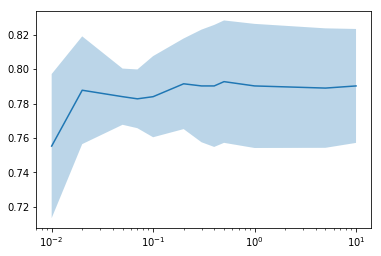

auc1: 0.9125188536953243


In [21]:
param_grid = {'C': [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10]}
cv = 5

estimator = LogisticRegression('l2')

lr2_model = GridSearchCV(estimator, param_grid, cv=cv)
lr2_model.fit(X_train, y_train)
plot_scores(lr2_model)

predicted_lr2 = lr2_model.predict_proba(X_test)
auc1 = roc_auc_score(y_test, predicted_lr2[:,1])

print("auc1: {}".format(auc1))

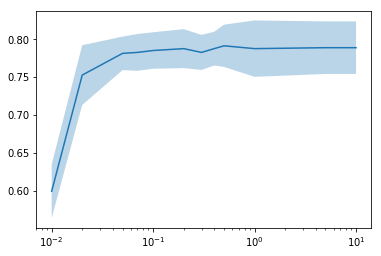

auc1: 0.9064856711915535


In [22]:
estimator = LogisticRegression('l1')

lr1_model = GridSearchCV(estimator, param_grid, cv=cv)
lr1_model.fit(X_train, y_train)
plot_scores(lr1_model)

predicted_lr1 = lr1_model.predict_proba(X_test)
auc1 = roc_auc_score(y_test, predicted_lr1[:,1])

print("auc1: {}".format(auc1))

## SVM

In [23]:
from sklearn.svm import SVC

In [24]:
svm_model = SVC(gamma='auto')

score = cross_val_score(svm_model, X, y, cv=10)
score_mean = score.mean()
print (score_mean)

0.7264374077857224


## XGBoost

In [25]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [26]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(801, 24) (801,)
(90, 24) (90,)


In [27]:
model = XGBClassifier()

In [28]:
xgb_model = model.fit(X_train, y_train)

In [29]:
from sklearn.metrics import classification_report

pred = xgb_model.predict(X_test)

print('XGboost Report %r' % (classification_report(y_test, pred)))

XGboost Report '             precision    recall  f1-score   support\n\n          0       0.84      0.94      0.89        51\n          1       0.91      0.77      0.83        39\n\navg / total       0.87      0.87      0.86        90\n'


/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Voting Classifier

In [30]:
from sklearn.ensemble import VotingClassifier

In [44]:
vt = VotingClassifier(estimators=[('lr2', lr2_model), ('rf', rf_model), 
                                  ('xgb', xgb_model), ('bc1', bc1_model), ('lr1', lr1_model)], voting='hard')
vt_model = vt.fit(X, y)

print(vt_model.predict(X))

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1
 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## VT submission

In [45]:
df = pd.read_csv('./test.csv')
passenger_ids = df['PassengerId'].to_numpy()
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [46]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [47]:
df.describe()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
count,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.677033,0.263158,0.033493,...,0.124402,0.078947,0.007177,0.004785,0.002392,0.002392,0.004785,0.244019,0.110048,0.645933
std,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.468170,0.440875,0.180135,...,0.330435,0.269980,0.084514,0.069088,0.048912,0.048912,0.069088,0.430019,0.313324,0.478803
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
df['Age'] = df['Age'].fillna(0)
df['Fare'] = df['Fare'].fillna(0)

In [49]:
X_testing_real_zeros = df[real_features].to_numpy()
X_testing_cat_zeros = df[cat_features].to_numpy()

X_testing_real_zeros_scaled = scaler.transform(X_testing_real_zeros)

print ("X_real: {} ".format(X_testing_real_zeros[0]))
print ("X_cat: {} ".format(X_testing_cat_zeros[0]))
print ("y: {} ".format(y[0]))

X_real: [34.5     7.8292] 
X_cat: [0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] 
y: 0 


In [50]:
print (df.shape)

(418, 25)


In [51]:
X_testing = np.hstack((X_testing_real_zeros_scaled, X_testing_cat_zeros))
#X_testing = X_testing[:,selected_features]

predicted = vt_model.predict(X_testing)

print (predicted)
print (passenger_ids)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]
[ 892  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  907  908  909  910  911  912  913  914  915  916  917  918  919
  920  92

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
with open("submission_vt2.txt", "w") as fout:
    fout.write("PassengerId,Survived\n")
    for val in zip(passenger_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))